In [1]:
# using GuSTO
include("../src/GuSTO.jl")
using AstrobeeRobot
using Plots
using JLD2, FileIO

┌ Info: Precompiling BulletCollision [b3564421-7037-56b3-90f4-5b7f54e2ead3]
└ @ Base loading.jl:1192


HTML{String}("    <script class='js-collapse-script'>\n        var curMatch =\n            window.location.href\n            .match(/(.*?)\\/notebooks\\/.*\\.ipynb/);\n\n        curMatch = curMatch ||\n            window.location.href\n            .match(/(.*?)\\/apps\\/.*\\.ipynb/);\n\n        if ( curMatch ) {\n            \$('head').append('<base href=\"' + curMatch[1] + '/\">');\n        }\n    </script>\n")

HTML{String}("<script class='js-collapse-script' src='/assetserver/75259c676c4c94b02ca26a89265c53e5a244a54a-assets/webio/dist/bundle.js'></script>")

HTML{String}("<script class='js-collapse-script' src='/assetserver/75259c676c4c94b02ca26a89265c53e5a244a54a-assets/providers/ijulia_setup.js'></script>")

HTML{String}("  <script class='js-collapse-script'>\n    \$('.js-collapse-script').parent('.output_subarea').css('padding', '0');\n  </script>\n")

In [2]:
robot = Freeflyer()
model = FreeflyerSE2()

FreeflyerSE2(6, 3, 0.05, Any[], Any[], Any[])

In [3]:
function setUpEnvironment()
    env = Table(:stanford);
    centers = Vector()
    push!(centers, [0.460; 0.315; 0.0])
    push!(centers, [0.201; 1.085; 0.0])
    push!(centers, [0.540; 2.020; 0.0])
    push!(centers, [1.374; 0.196; 0.0])
    push!(centers, [1.063; 1.354; 0.0])
    push!(centers, [1.365; 2.322; 0.0])
    push!(centers, [2.221; 0.548; 0.0])
    push!(centers, [2.077; 1.443; 0.0])
    push!(centers, [3.098; 1.186; 0.0])
    push!(centers, [2.837; 2.064; 0.0])
    # push!(centers, [1.500; 1.500; 0.0])

    widths = [0.27; 0.27; 0.127]
    inflation = 0.05*ones(3)

    for idx in 1:length(centers)
        push!(env.obstacle_set, HyperRectangle(Vec3f0(centers[idx]-0.5*widths-inflation+[0.;0.;0.5*widths[1]]), Vec3f0(widths+2*inflation)))
    end
    return env
end

setUpEnvironment (generic function with 1 method)

In [4]:
# Create obstacle grid representation using centers, widths, and inflation


In [5]:
# Set up problem, initial goal and final goal
function setUpProblem(N, x_init, x_goal)
    tf_guess = 200.
    goal_set = GoalSet()
    add_goal!(goal_set, Goal(PointGoal(x_goal), tf_guess, model))
    PD = ProblemDefinition(robot, model, env, x_init, goal_set)
    TOP = TrajectoryOptimizationProblem(PD, N, tf_guess, fixed_final_time=true)
    TOSgusto = TrajectoryOptimizationSolution(TOP)
    return TOP, TOSgusto
end


setUpProblem (generic function with 1 method)

In [6]:
function plotVelocity(TOSgusto, N)
    gr(fmt=:png)
    plot()
    plot!([collect(1:N)],[sqrt.(TOSgusto.SCPS.traj.X[4,:].^2 + TOSgusto.SCPS.traj.X[5,:].^2)],
        xlabel = "t",
        ylabel = "v",
        legend = :none)
    plot!()
end

plotVelocity (generic function with 1 method)

In [7]:
#### Code for animating free-flyer trajectories
function visualizeTraj(env, TOSgusto)
    vis = Visualizer()
    delete!(vis)

    vis[:goal]
    setobject!(vis[:goal][:goal], 
        Object(HyperSphere(Point3(x_goal[1:2]..., robot.r), 0.1),
            MeshBasicMaterial(color=RGBA(0,1.0,0.,0.3))))

    vis[:table]
    table_dim = env.worldAABBmax-env.worldAABBmin
    setobject!(vis[:table][:table], 
            Object(HyperRectangle(env.worldAABBmin..., table_dim...),
                MeshBasicMaterial(color=RGBA(0,1.0,0.,0.3))))

    vis[:obstacles]
    for (idx,obs) in enumerate(env.obstacle_set)
        setobject!(vis[:obstacles][Symbol(string("obs",idx))], 
            Object(obs,MeshBasicMaterial(color=RGBA(1.0,0.,0.,0.3))))
    end

    vis[:robot]

    setobject!(vis[:robot][:base],
        Object(Cylinder(Point3f0(0,0,0.),Point3f0(0.,0.,0.5),Float32(robot.r)),MeshBasicMaterial(color=RGBA(0,0.,1.,0.7))))

    up = [0;0;1.]
    q0 = vec2quat(up,x_init[3])
    Qs = Vector{Vector{Float64}}()

    speed_factor = 10

    for k in 1:speed_factor:N
        q = [quat_inv(quat_multiply(mrp2quat([0.; 0.; tan(TOSgusto.SCPS.traj.X[3,k]/4)]), q0)); [TOSgusto.SCPS.traj.X[1:2,k]; robot.r]]
        push!(Qs,q)
    end

    anim = MeshCat.Animation()
    for k in 1:N
        atframe(anim, vis, 5*k) do frame
            settransform!(frame[:robot], Translation(TOSgusto.traj.X[1,k], 
                TOSgusto.traj.X[2,k], TOSgusto.traj.X[3,k]))
        end
    end
    setanimation!(vis, anim)

    # plot_in_cell = true
    plot_in_cell = false
    plot_in_cell ? IJuliaCell(vis) : open(vis)
end

visualizeTraj (generic function with 1 method)

In [8]:
function createTrainingInputAndOutput(traj_X_vec, traj_U_vec, ω_vec, Δ_vec)
    X_row = hcat((map(a -> a[:], traj_X_vec))...)'
    U_row = hcat((map(a -> a[:], traj_U_vec))...)'

    train_input = hcat(X_row, U_row, ω_vec, Δ_vec)[1:end-1,:]

    diff_X = traj_X_vec[2:end]-traj_X_vec[1:end-1]
    diff_U = traj_U_vec[2:end]-traj_U_vec[1:end-1]
    diff_X_row = hcat((map(a -> a[:], diff_X))...)'
    diff_U_row = hcat((map(a -> a[:], diff_U))...)'

    train_output = hcat(diff_X_row, diff_U_row)
    
    if size(train_input,1) != size(train_output,1)
        println("ERROR: train input and output have different # of rows")
    end
    if size(train_input,2) - 2 != size(train_output,2)
        println("ERROR: each row of train input should 2 elements more than output")
    end
    
    return train_input, train_output
    
end

createTrainingInputAndOutput (generic function with 1 method)

In [9]:
function recoverProblemConditionsFromTrainInput(train_input) 
    recover_x_init_from_train = train_input[1,1:6]
    @show recover_x_init_from_train
    recover_x_goal_from_train = train_input[1,(6*N-5):(6*N + 1)]
    @show recover_x_goal_from_train
    # NOTE that size(train_input,2)-2 = x_dim * N
end
function recoverProblemConditionsFromTrajVec(traj_X_vec) 
    recover_x_init = traj_X_vec[1][:,1]
    @show recover_x_init
    recover_x_goal = traj_X_vec[1][:,end]
    @show recover_x_goal
    # NOTE that size(traj_X_vec[1]) = (x_dim * N)
end

recoverProblemConditionsFromTrajVec (generic function with 1 method)

In [ ]:
# Generate training data
# Keep environment constant and goal constant 
env = setUpEnvironment()
N = 20
x_goal = [3.; 0.5; 0; 0.05; -0.05; 0]
num_problems = 1000
numInEach = sqrt(num_problems)
xMin = 0.2
xMax = 2.5
yMin = 0.8 
yMax = 3.0
xVals = collect(xMin:(xMax-xMin)/floor(numInEach-1):xMax)
yVals = collect(yMin:(yMax-yMin)/floor(numInEach-1):yMax)
# @show xVals
# @show yVals

max_iter = 30

train_input_collected = Array{Float64}(undef,0,182)
train_output_collected = Array{Float64}(undef,0,180)

problemNumber = 1
for xVal in xVals
    for yVal in yVals
        println("")
        @show problemNumber
        x_init = [xVal; yVal; 0; 0; 0; 0] 
#         @show x_init
        TOP, TOSgusto = setUpProblem(N, x_init, x_goal);
        traj_init = init_traj_straightline(TOP)
        traj_X_vec = [traj_init.X]
        traj_U_vec = [traj_init.U]
        # Solve one step at a time with IPOPT
        solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, traj_init, "Ipopt", max_iter=1, print_level=0);
        push!(traj_X_vec, TOSgusto.SCPS.traj.X)
        push!(traj_U_vec, TOSgusto.SCPS.traj.U)
        iterCount = 1
        
        while !TOSgusto.SCPS.converged && iterCount <=max_iter && (TOSgusto.SCPS.solver_status[end] == MOI.LOCALLY_SOLVED)
            solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, TOSgusto.SCPS.traj, "Ipopt", max_iter=1, print_level=0);
#             @show TOSgusto.SCPS.scp_status
#             @show TOSgusto.SCPS.solver_status
#             @show TOSgusto.SCPS.accept_solution
#             @show TOSgusto.SCPS.param.alg.ω_vec
            if TOSgusto.SCPS.solver_status[end] == MOI.LOCALLY_SOLVED
                push!(traj_X_vec, TOSgusto.SCPS.traj.X)
                push!(traj_U_vec, TOSgusto.SCPS.traj.U)
                iterCount = iterCount + 1
                @show iterCount
            end
        end
        train_input, train_output = createTrainingInputAndOutput(traj_X_vec, traj_U_vec, TOSgusto.SCPS.param.alg.ω_vec, TOSgusto.SCPS.param.alg.Δ_vec)
#         @show size(train_input)
#         @show size(train_output)
        train_input_collected = vcat(train_input_collected, train_input)
        train_output_collected = vcat(train_output_collected, train_output)
        problemNumber = problemNumber + 1
        @save "secondBatch.jld2" train_input_collected train_output_collected
    end
end

# @save "firstBatch.jld2" train_input_collected train_output_collected



problemNumber = 1
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
iterCount = 6

problemNumber = 2
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
iterCount = 6

problemNumber = 3
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
iterCount = 6

problemNumber = 4
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
iterCount = 6

problemNumber = 5
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
iterCount = 6

problemNumber = 6
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
iterCount = 6

problemNumber = 7
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
iterCount = 6

problemNumber = 8
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
iterCount = 6

problemNumber = 9
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
iterCount = 6

problemNumber = 10
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
iterCount = 6

problemNumber = 11
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
iterCount = 6
iterCount = 7
iterC


problemNumber = 84
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
iterCount = 6

problemNumber = 85
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
iterCount = 6
iterCount = 7
iterCount = 8
iterCount = 9

problemNumber = 86
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
iterCount = 6
iterCount = 7
iterCount = 8

problemNumber = 87
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
iterCount = 6

problemNumber = 88
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
iterCount = 6

problemNumber = 89
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
iterCount = 6

problemNumber = 90
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
iterCount = 6

problemNumber = 91
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
iterCount = 6

problemNumber = 92
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
iterCount = 6

problemNumber = 93
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
iterCount = 6

problemNumber = 94
iterCount 

iterCount = 4
iterCount = 5
iterCount = 6

problemNumber = 235
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
iterCount = 6

problemNumber = 236
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
iterCount = 6

problemNumber = 237
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
iterCount = 6

problemNumber = 238
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
iterCount = 6

problemNumber = 239
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
iterCount = 6

problemNumber = 240
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
iterCount = 6
iterCount = 7

problemNumber = 241
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
iterCount = 6
iterCount = 7
iterCount = 8
iterCount = 9
iterCount = 10
iterCount = 11
iterCount = 12
iterCount = 13

problemNumber = 242
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
iterCount = 6

problemNumber = 243
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
iterCount = 6

problemNumber = 244
it


problemNumber = 314
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
iterCount = 6

problemNumber = 315
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 316
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
iterCount = 6

problemNumber = 317
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
iterCount = 6

problemNumber = 318
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
iterCount = 6

problemNumber = 319
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
iterCount = 6

problemNumber = 320
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
iterCount = 6

problemNumber = 321
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
iterCount = 6

problemNumber = 322
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
iterCount = 6

problemNumber = 323
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
iterCount = 6

problemNumber = 324
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
iterCount = 6
iterCount = 7

iterCount = 5
iterCount = 6

problemNumber = 473
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
iterCount = 6

problemNumber = 474
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
iterCount = 6

problemNumber = 475
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 476
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 477
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
iterCount = 6

problemNumber = 478
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
iterCount = 6

problemNumber = 479
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 480
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
iterCount = 6
iterCount = 7
iterCount = 8
iterCount = 9
iterCount = 10
iterCount = 11

problemNumber = 481
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
iterCount = 6
iterCount = 7
iterCount = 8

problemNumber = 482
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
iterCount = 6

pro

In [18]:
# Generate training data
# Keep environment constant and goal constant 
env = setUpEnvironment()
N = 20
x_goal = [3.; 0.5; 0; 0.05; -0.05; 0]
num_problems = 100
numInEach = sqrt(num_problems)
xMin = 0.2
xMax = 2.5
yMin = 0.8 
yMax = 3.0
xVals = collect(xMin:(xMax-xMin)/floor(numInEach-1):xMax)
yVals = collect(yMin:(yMax-yMin)/floor(numInEach-1):yMax)
# @show xVals
# @show yVals

max_iter = 30

train_input_collected = Array{Float64}(undef,0,182)
train_output_collected = Array{Float64}(undef,0,180)

problemNumber = 1
for xVal in xVals
    for yVal in yVals
        println("")
        @show problemNumber
        x_init = [xVal; yVal; 0; 0; 0; 0] 
        @show x_init
        TOP, TOSgusto = setUpProblem(N, x_init, x_goal);
        traj_init = init_traj_straightline(TOP)
        traj_X_vec = [traj_init.X]
        traj_U_vec = [traj_init.U]
        # Solve one step at a time with IPOPT
        solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, traj_init, "Ipopt", max_iter=1, print_level=0);
        push!(traj_X_vec, TOSgusto.SCPS.traj.X)
        push!(traj_U_vec, TOSgusto.SCPS.traj.U)
        iterCount = 1
        
        while !TOSgusto.SCPS.converged && iterCount <=max_iter && (TOSgusto.SCPS.solver_status[end] == MOI.LOCALLY_SOLVED)
            solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, TOSgusto.SCPS.traj, "Ipopt", max_iter=1, print_level=0);
            @show TOSgusto.SCPS.scp_status
            @show TOSgusto.SCPS.solver_status
#             @show TOSgusto.SCPS.accept_solution
#             @show TOSgusto.SCPS.param.alg.ω_vec
            if TOSgusto.SCPS.solver_status[end] == MOI.LOCALLY_SOLVED
                push!(traj_X_vec, TOSgusto.SCPS.traj.X)
                push!(traj_U_vec, TOSgusto.SCPS.traj.U)
                iterCount = iterCount + 1
                @show iterCount
            end
        end
        train_input, train_output = createTrainingInputAndOutput(traj_X_vec, traj_U_vec, TOSgusto.SCPS.param.alg.ω_vec, TOSgusto.SCPS.param.alg.Δ_vec)
        @show size(train_input)
        @show size(train_output)
        train_input_collected = vcat(train_input_collected, train_input)
        train_output_collected = vcat(train_output_collected, train_output)
        problemNumber = problemNumber + 1
        @save "firstBatch.jld2" train_input_collected train_output_collected
    end
end

# @save "firstBatch.jld2" train_input_collected train_output_collected



problemNumber = 1
x_init = [0.2, 0.8, 0.0, 0.0, 0.0, 0.0]
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints]
(TOSgusto.SCPS).solver_status = Union{TerminationStatusCode, Symbol}[:NA, LOCALLY_SOLVED, LOCALLY_SOLVED]
iterCount = 2
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
(TOSgusto.SCPS).solver_status = Union{TerminationStatusCode, Symbol}[:NA, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED]
iterCount = 3
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
(TOSgusto.SCPS).solver_status = Union{TerminationStatusCode, Symbol}[:NA, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED]
iterCount = 4
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
(TOSgusto.SCPS).solver_status = Union{TerminationStatusCode, 

(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints]
(TOSgusto.SCPS).solver_status = Union{TerminationStatusCode, Symbol}[:NA, LOCALLY_SOLVED, LOCALLY_SOLVED]
iterCount = 2
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
(TOSgusto.SCPS).solver_status = Union{TerminationStatusCode, Symbol}[:NA, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED]
iterCount = 3
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
(TOSgusto.SCPS).solver_status = Union{TerminationStatusCode, Symbol}[:NA, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED]
iterCount = 4
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
(TOSgusto.SCPS).solver_status = Union{TerminationStatusCode, Symbol}[:NA, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED

(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
(TOSgusto.SCPS).solver_status = Union{TerminationStatusCode, Symbol}[:NA, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED]
iterCount = 4
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
(TOSgusto.SCPS).solver_status = Union{TerminationStatusCode, Symbol}[:NA, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED]
iterCount = 5
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
(TOSgusto.SCPS).solver_status = Union{TerminationStatusCode, Symbol}[:NA, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED]
iterCount = 6
size(train_input) = (6, 182)
size(train_out

(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints]
(TOSgusto.SCPS).solver_status = Union{TerminationStatusCode, Symbol}[:NA, LOCALLY_SOLVED, LOCALLY_SOLVED]
iterCount = 2
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
(TOSgusto.SCPS).solver_status = Union{TerminationStatusCode, Symbol}[:NA, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED]
iterCount = 3
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
(TOSgusto.SCPS).solver_status = Union{TerminationStatusCode, Symbol}[:NA, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED]
iterCount = 4
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
(TOSgusto.SCPS).solver_status = Union{TerminationStatusCode, Symbol}[:NA, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED

(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :OK, :OK, :OK, :OK]
(TOSgusto.SCPS).solver_status = Union{TerminationStatusCode, Symbol}[:NA, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED]
iterCount = 5
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :OK, :OK, :OK, :OK, :OK]
(TOSgusto.SCPS).solver_status = Union{TerminationStatusCode, Symbol}[:NA, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED]
iterCount = 6
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :OK, :OK, :OK, :OK, :OK, :OK]
(TOSgusto.SCPS).solver_status = Union{TerminationStatusCode, Symbol}[:NA, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED]
iterCount = 7
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :OK, :OK, :OK, :OK, :OK, :OK, :OK]
(TOSgusto.SCPS).solver_status = Union{TerminationStatusCode, Symbol}[:NA, LOCALLY_SOLV

(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
(TOSgusto.SCPS).solver_status = Union{TerminationStatusCode, Symbol}[:NA, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED]
iterCount = 5
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
(TOSgusto.SCPS).solver_status = Union{TerminationStatusCode, Symbol}[:NA, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED]
iterCount = 6
size(train_input) = (6, 182)
size(train_output) = (6, 180)

problemNumber = 25
x_init = [0.711111, 1.77778, 0.0, 0.0, 0.0, 0.0]
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints]
(TOSgusto.SCPS).solver_status = Union{TerminationStatusCode, Symbol}[:NA, LOCALLY_SOLVED, LOCALLY_SOLVED]
iterC

(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints]
(TOSgusto.SCPS).solver_status = Union{TerminationStatusCode, Symbol}[:NA, LOCALLY_SOLVED, LOCALLY_SOLVED]
iterCount = 2
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
(TOSgusto.SCPS).solver_status = Union{TerminationStatusCode, Symbol}[:NA, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED]
iterCount = 3
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
(TOSgusto.SCPS).solver_status = Union{TerminationStatusCode, Symbol}[:NA, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED]
iterCount = 4
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
(TOSgusto.SCPS).solver_status = Union{TerminationStatusCode, Symbol}[:NA, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED

(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
(TOSgusto.SCPS).solver_status = Union{TerminationStatusCode, Symbol}[:NA, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED]
iterCount = 4
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
(TOSgusto.SCPS).solver_status = Union{TerminationStatusCode, Symbol}[:NA, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED]
iterCount = 5
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
(TOSgusto.SCPS).solver_status = Union{TerminationStatusCode, Symbol}[:NA, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED]
iterCount = 6
size(train_input) = (6, 182)
size(train_out

(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :OK, :OK]
(TOSgusto.SCPS).solver_status = Union{TerminationStatusCode, Symbol}[:NA, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED]
iterCount = 3
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :OK, :OK, :OK]
(TOSgusto.SCPS).solver_status = Union{TerminationStatusCode, Symbol}[:NA, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED]
iterCount = 4
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :OK, :OK, :OK, :OK]
(TOSgusto.SCPS).solver_status = Union{TerminationStatusCode, Symbol}[:NA, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED]
iterCount = 5
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :OK, :OK, :OK, :OK, :OK]
(TOSgusto.SCPS).solver_status = Union{TerminationStatusCode, Symbol}[:NA, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED]
iterCount = 6
(TOSgusto.SCPS).scp_status = Symbol[:N


problemNumber = 41
x_init = [1.22222, 0.8, 0.0, 0.0, 0.0, 0.0]
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :OK]
(TOSgusto.SCPS).solver_status = Union{TerminationStatusCode, Symbol}[:NA, LOCALLY_SOLVED, LOCALLY_SOLVED]
iterCount = 2
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :OK, :OK]
(TOSgusto.SCPS).solver_status = Union{TerminationStatusCode, Symbol}[:NA, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED]
iterCount = 3
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :OK, :OK, :OK]
(TOSgusto.SCPS).solver_status = Union{TerminationStatusCode, Symbol}[:NA, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED]
iterCount = 4
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :OK, :OK, :OK, :OK]
(TOSgusto.SCPS).solver_status = Union{TerminationStatusCode, Symbol}[:NA, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED]
iterCount = 5
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstrai

(TOSgusto.SCPS).scp_status = Symbol[:NA, :OK, :OK, :OK, :OK, :OK, :OK, :OK]
(TOSgusto.SCPS).solver_status = Union{TerminationStatusCode, Symbol}[:NA, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED]
iterCount = 7
size(train_input) = (7, 182)
size(train_output) = (7, 180)

problemNumber = 46
x_init = [1.22222, 2.02222, 0.0, 0.0, 0.0, 0.0]
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints]
(TOSgusto.SCPS).solver_status = Union{TerminationStatusCode, Symbol}[:NA, LOCALLY_SOLVED, LOCALLY_SOLVED]
iterCount = 2
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
(TOSgusto.SCPS).solver_status = Union{TerminationStatusCode, Symbol}[:NA, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED]
iterCount = 3
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
(TOSgusto.SCPS).solv

(TOSgusto.SCPS).scp_status = Symbol[:NA, :OK, :OK, :OK]
(TOSgusto.SCPS).solver_status = Union{TerminationStatusCode, Symbol}[:NA, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED]
iterCount = 3
(TOSgusto.SCPS).scp_status = Symbol[:NA, :OK, :OK, :OK, :OK]
(TOSgusto.SCPS).solver_status = Union{TerminationStatusCode, Symbol}[:NA, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED]
iterCount = 4
(TOSgusto.SCPS).scp_status = Symbol[:NA, :OK, :OK, :OK, :OK, :OK]
(TOSgusto.SCPS).solver_status = Union{TerminationStatusCode, Symbol}[:NA, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED]
iterCount = 5
(TOSgusto.SCPS).scp_status = Symbol[:NA, :OK, :OK, :OK, :OK, :OK, :OK]
(TOSgusto.SCPS).solver_status = Union{TerminationStatusCode, Symbol}[:NA, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED]
iterCount = 6
size(train_input) = (6, 182)
size(train_output) = (6, 180)

problemNumber = 52
x_init = [1.47778, 1.04444,

(TOSgusto.SCPS).scp_status = Symbol[:NA, :OK, :OK]
(TOSgusto.SCPS).solver_status = Union{TerminationStatusCode, Symbol}[:NA, LOCALLY_SOLVED, LOCALLY_SOLVED]
iterCount = 2
(TOSgusto.SCPS).scp_status = Symbol[:NA, :OK, :OK, :OK]
(TOSgusto.SCPS).solver_status = Union{TerminationStatusCode, Symbol}[:NA, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED]
iterCount = 3
(TOSgusto.SCPS).scp_status = Symbol[:NA, :OK, :OK, :OK, :OK]
(TOSgusto.SCPS).solver_status = Union{TerminationStatusCode, Symbol}[:NA, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED]
iterCount = 4
(TOSgusto.SCPS).scp_status = Symbol[:NA, :OK, :OK, :OK, :OK, :OK]
(TOSgusto.SCPS).solver_status = Union{TerminationStatusCode, Symbol}[:NA, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED]
iterCount = 5
(TOSgusto.SCPS).scp_status = Symbol[:NA, :OK, :OK, :OK, :OK, :OK, :OK]
(TOSgusto.SCPS).solver_status = Union{TerminationStatusCode, Symbol}[:NA, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVE

(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
(TOSgusto.SCPS).solver_status = Union{TerminationStatusCode, Symbol}[:NA, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED]
iterCount = 5
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
(TOSgusto.SCPS).solver_status = Union{TerminationStatusCode, Symbol}[:NA, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED]
iterCount = 6
size(train_input) = (6, 182)
size(train_output) = (6, 180)

problemNumber = 61
x_init = [1.73333, 0.8, 0.0, 0.0, 0.0, 0.0]
(TOSgusto.SCPS).scp_status = Symbol[:NA, :OK, :OK]
(TOSgusto.SCPS).solver_status = Union{TerminationStatusCode, Symbol}[:NA, LOCALLY_SOLVED, LOCALLY_SOLVED]
iterCount = 2
(TOSgusto.SCPS).scp_status = S


problemNumber = 65
x_init = [1.73333, 1.77778, 0.0, 0.0, 0.0, 0.0]
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :OK]
(TOSgusto.SCPS).solver_status = Union{TerminationStatusCode, Symbol}[:NA, LOCALLY_SOLVED, LOCALLY_SOLVED]
iterCount = 2
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :OK, :OK]
(TOSgusto.SCPS).solver_status = Union{TerminationStatusCode, Symbol}[:NA, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED]
iterCount = 3
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :OK, :OK, :OK]
(TOSgusto.SCPS).solver_status = Union{TerminationStatusCode, Symbol}[:NA, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED]
iterCount = 4
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :OK, :OK, :OK, :OK]
(TOSgusto.SCPS).solver_status = Union{TerminationStatusCode, Symbol}[:NA, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED]
iterCount = 5
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesCons

(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
(TOSgusto.SCPS).solver_status = Union{TerminationStatusCode, Symbol}[:NA, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED]
iterCount = 6
size(train_input) = (6, 182)
size(train_output) = (6, 180)

problemNumber = 75
x_init = [1.98889, 1.77778, 0.0, 0.0, 0.0, 0.0]
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints]
(TOSgusto.SCPS).solver_status = Union{TerminationStatusCode, Symbol}[:NA, LOCALLY_SOLVED, LOCALLY_SOLVED]
iterCount = 2
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
(TOSgusto.SCPS).solver_status = Union{TerminationStatusCode, Symbol}[:NA, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED]
iterCount = 3
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :Viol

(TOSgusto.SCPS).scp_status = Symbol[:NA, :OK, :OK, :OK, :OK, :OK, :OK]
(TOSgusto.SCPS).solver_status = Union{TerminationStatusCode, Symbol}[:NA, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED]
iterCount = 6
(TOSgusto.SCPS).scp_status = Symbol[:NA, :OK, :OK, :OK, :OK, :OK, :OK, :OK]
(TOSgusto.SCPS).solver_status = Union{TerminationStatusCode, Symbol}[:NA, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED]
iterCount = 7
(TOSgusto.SCPS).scp_status = Symbol[:NA, :OK, :OK, :OK, :OK, :OK, :OK, :OK, :OK]
(TOSgusto.SCPS).solver_status = Union{TerminationStatusCode, Symbol}[:NA, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED]
iterCount = 8
(TOSgusto.SCPS).scp_status = Symbol[:NA, :OK, :OK, :OK, :OK, :OK, :OK, :OK, :OK, :OK]
(TOSgusto.SCPS).solver_status = Union{TerminationStatusCode, Symbol}[:NA, LOCALLY_SOLV


problemNumber = 83
x_init = [2.24444, 1.28889, 0.0, 0.0, 0.0, 0.0]
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints]
(TOSgusto.SCPS).solver_status = Union{TerminationStatusCode, Symbol}[:NA, LOCALLY_SOLVED, LOCALLY_SOLVED]
iterCount = 2
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
(TOSgusto.SCPS).solver_status = Union{TerminationStatusCode, Symbol}[:NA, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED]
iterCount = 3
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
(TOSgusto.SCPS).solver_status = Union{TerminationStatusCode, Symbol}[:NA, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED]
iterCount = 4
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
(TOSgusto.SCPS).solver_status = Union{TerminationSta

(TOSgusto.SCPS).scp_status = Symbol[:NA, :OK, :OK, :OK, :OK, :OK, :OK]
(TOSgusto.SCPS).solver_status = Union{TerminationStatusCode, Symbol}[:NA, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED]
iterCount = 6
(TOSgusto.SCPS).scp_status = Symbol[:NA, :OK, :OK, :OK, :OK, :OK, :OK, :OK]
(TOSgusto.SCPS).solver_status = Union{TerminationStatusCode, Symbol}[:NA, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED]
iterCount = 7
(TOSgusto.SCPS).scp_status = Symbol[:NA, :OK, :OK, :OK, :OK, :OK, :OK, :OK, :OK]
(TOSgusto.SCPS).solver_status = Union{TerminationStatusCode, Symbol}[:NA, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED]
iterCount = 8
(TOSgusto.SCPS).scp_status = Symbol[:NA, :OK, :OK, :OK, :OK, :OK, :OK, :OK, :OK, :OK]
(TOSgusto.SCPS).solver_status = Union{TerminationStatusCode, Symbol}[:NA, LOCALLY_SOLV


problemNumber = 92
x_init = [2.5, 1.04444, 0.0, 0.0, 0.0, 0.0]
(TOSgusto.SCPS).scp_status = Symbol[:NA, :OK, :OK]
(TOSgusto.SCPS).solver_status = Union{TerminationStatusCode, Symbol}[:NA, LOCALLY_SOLVED, LOCALLY_SOLVED]
iterCount = 2
(TOSgusto.SCPS).scp_status = Symbol[:NA, :OK, :OK, :OK]
(TOSgusto.SCPS).solver_status = Union{TerminationStatusCode, Symbol}[:NA, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED]
iterCount = 3
(TOSgusto.SCPS).scp_status = Symbol[:NA, :OK, :OK, :OK, :OK]
(TOSgusto.SCPS).solver_status = Union{TerminationStatusCode, Symbol}[:NA, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED]
iterCount = 4
(TOSgusto.SCPS).scp_status = Symbol[:NA, :OK, :OK, :OK, :OK, :OK]
(TOSgusto.SCPS).solver_status = Union{TerminationStatusCode, Symbol}[:NA, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED]
iterCount = 5
(TOSgusto.SCPS).scp_status = Symbol[:NA, :OK, :OK, :OK, :OK, :OK, :OK]
(TOSgusto.SCPS).solver_status = Union{TerminationStatus

(TOSgusto.SCPS).scp_status = Symbol[:NA, :OK, :OK, :OK, :OK, :OK]
(TOSgusto.SCPS).solver_status = Union{TerminationStatusCode, Symbol}[:NA, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED]
iterCount = 5
(TOSgusto.SCPS).scp_status = Symbol[:NA, :OK, :OK, :OK, :OK, :OK, :OK]
(TOSgusto.SCPS).solver_status = Union{TerminationStatusCode, Symbol}[:NA, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED]
iterCount = 6
(TOSgusto.SCPS).scp_status = Symbol[:NA, :OK, :OK, :OK, :OK, :OK, :OK, :OK]
(TOSgusto.SCPS).solver_status = Union{TerminationStatusCode, Symbol}[:NA, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED]
iterCount = 7
(TOSgusto.SCPS).scp_status = Symbol[:NA, :OK, :OK, :OK, :OK, :OK, :OK, :OK, :OK]
(TOSgusto.SCPS).solver_status = Union{TerminationStatusCode, Symbol}[:NA, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, 

(TOSgusto.SCPS).scp_status = Symbol[:NA, :OK, :OK, :OK, :OK, :OK, :OK, :OK]
(TOSgusto.SCPS).solver_status = Union{TerminationStatusCode, Symbol}[:NA, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED]
iterCount = 7
(TOSgusto.SCPS).scp_status = Symbol[:NA, :OK, :OK, :OK, :OK, :OK, :OK, :OK, :OK]
(TOSgusto.SCPS).solver_status = Union{TerminationStatusCode, Symbol}[:NA, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED]
iterCount = 8
(TOSgusto.SCPS).scp_status = Symbol[:NA, :OK, :OK, :OK, :OK, :OK, :OK, :OK, :OK, :OK]
(TOSgusto.SCPS).solver_status = Union{TerminationStatusCode, Symbol}[:NA, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED]
iterCount = 9
(TOSgusto.SCPS).scp_status = Symbol[:NA, :OK, :OK, :OK, :OK, :OK, :OK, :OK, :OK, :OK, :OK]
(TOSgusto.SCPS).so

In [70]:
# Violates constraints start point
env = setUpEnvironment()
N = 20
x_init = [0.6; 2.4; 0; 0; 0; 0]
x_goal = [3.; 0.5; 0; 0.05; -0.05; 0]
TOP, TOSgusto = setUpProblem(N, x_init, x_goal);
# Solve full solution with IPOPT
full_SCPS = solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, init_traj_straightline, "Ipopt", max_iter=100, print_level=0);


In [71]:
@show TOSgusto.SCPS.scp_status
@show TOSgusto.SCPS.iterations
@show TOSgusto.SCPS.converged
@show TOSgusto.SCPS.param.alg.ω_vec
@show TOSgusto.SCPS.param.alg.Δ_vec

(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
(TOSgusto.SCPS).iterations = 6
(TOSgusto.SCPS).converged = true
(((TOSgusto.SCPS).param).alg).ω_vec = [1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0, 1.0e6]
(((TOSgusto.SCPS).param).alg).Δ_vec = [3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0]


7-element Array{Float64,1}:
 3.0
 3.0
 3.0
 3.0
 3.0
 3.0
 3.0

In [134]:
# Violates constraints start point
env = setUpEnvironment()
N = 20
x_init = [0.6; 2.4; 0; 0; 0; 0]
x_goal = [3.; 0.5; 0; 0.05; -0.05; 0]
TOP, TOSgusto = setUpProblem(N, x_init, x_goal);

traj_init = init_traj_straightline(TOP)
traj_X_vec = [traj_init.X]
traj_U_vec = [traj_init.U]
# Solve one step at a time with IPOPT
solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, traj_init, "Ipopt", max_iter=1, print_level=0);
push!(traj_X_vec, TOSgusto.SCPS.traj.X)
push!(traj_U_vec, TOSgusto.SCPS.traj.U)
iterCount = 1

while !TOSgusto.SCPS.converged && iterCount <=50
    solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, TOSgusto.SCPS.traj, "Ipopt", max_iter=1, print_level=0);
    push!(traj_X_vec, TOSgusto.SCPS.traj.X)
    push!(traj_U_vec, TOSgusto.SCPS.traj.U)
    iterCount = iterCount + 1
    @show iterCount 
#     @show TOSgusto.SCPS.param.alg.ω_vec
#     @show TOSgusto.SCPS.param.alg.Δ_vec
end
println("Finished!")
@show TOSgusto.SCPS.scp_status
@show TOSgusto.SCPS.iterations
@show TOSgusto.SCPS.converged
@show TOSgusto.SCPS.param.alg.ω_vec
@show TOSgusto.SCPS.param.alg.Δ_vec
@show size(traj_X_vec)



iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
iterCount = 6
Finished!
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
(TOSgusto.SCPS).iterations = 6
(TOSgusto.SCPS).converged = true
(((TOSgusto.SCPS).param).alg).ω_vec = [1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0, 1.0e6]
(((TOSgusto.SCPS).param).alg).Δ_vec = [3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0]
size(traj_X_vec) = (7,)


(7,)

In [136]:
train_input, train_output = createTrainingInputAndOutput(traj_X_vec, traj_U_vec, TOSgusto.SCPS.param.alg.ω_vec, TOSgusto.SCPS.param.alg.Δ_vec)
@show size(train_input)
@show size(train_output)


size(train_input) = (6, 182)
size(train_output) = (6, 180)


(6, 180)

In [81]:
traj_X_vec_3d=cat(traj_X_vec...,dims=3)
@show size(traj_X_vec_3d)

using JLD2, FileIO
hello = "world"
foo = :bar
@save "example.jld2" hello foo

size(traj_X_vec_3d) = (6, 20, 7)


┌ Info: Precompiling JLD2 [033835bb-8acc-5ee8-8aae-3f567f8a3819]
└ @ Base loading.jl:1192


In [18]:
# OK start point
env = setUpEnvironment()
N = 20
x_init = [0.2; 2.4; 0; 0; 0; 0]
x_goal = [3.; 0.5; 0; 0.05; -0.05; 0]
TOP, TOSgusto = setUpProblem(N, x_init, x_goal);
# Solve full solution with IPOPT
full_SCPS = solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, init_traj_straightline, "Ipopt", max_iter=100, print_level=0);


In [19]:
@show TOSgusto.SCPS.scp_status
@show TOSgusto.SCPS.iterations
@show TOSgusto.SCPS.converged
@show TOSgusto.SCPS.param.alg.ω_vec
@show TOSgusto.SCPS.param.alg.Δ_vec

(TOSgusto.SCPS).scp_status = Symbol[:NA, :OK, :OK, :OK, :OK, :OK, :OK, :OK, :OK]
(TOSgusto.SCPS).iterations = 8
(TOSgusto.SCPS).converged = true
(((TOSgusto.SCPS).param).alg).ω_vec = [2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0]
(((TOSgusto.SCPS).param).alg).Δ_vec = [4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0]


9-element Array{Float64,1}:
 4.0
 4.0
 4.0
 4.0
 4.0
 4.0
 4.0
 4.0
 4.0

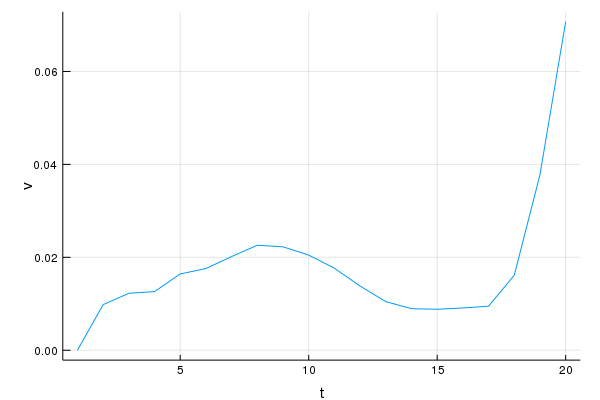

In [64]:
plotVelocity(TOSgusto, N)

In [65]:
visualizeTraj(env, TOSgusto)

┌ Info: Serving MeshCat visualizer at http://127.0.0.1:8701
└ @ MeshCat /home/somrita/.julia/packages/MeshCat/WlA0B/src/servers.jl:24


Process(`xdg-open http://127.0.0.1:8701`, ProcessExited(0))

[15132:15144:0509/164725.644705:ERROR:browser_process_sub_thread.cc(217)] Waited 9 ms for network service


Opening in existing browser session.


In [70]:
# Solve full solution with Gurobi
env = setUpEnvironment()
N = 20
x_init = [0.4; 2.4; 0; 0; 0; 0]
x_goal = [3.; 0.5; 0; 0.05; -0.05; 0]
TOP, TOSgusto = setUpProblem(N, x_init, x_goal);
full_SCPS = solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, init_traj_straightline, "Gurobi", max_iter=100, OutputFlag=0);
@show TOSgusto.SCPS.scp_status
@show TOSgusto.SCPS.iterations
@show TOSgusto.SCPS.accept_solution
# visualizeTraj(env, TOSgusto)

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
(TOSgusto.SCPS).iterations = 6
(TOSgusto.SCPS).accept_solution = Bool[true, true, true, true, true, true, true]


7-element Array{Bool,1}:
 true
 true
 true
 true
 true
 true
 true

In [13]:
# Create loop to run SCP one iteration at a time and store off TOSgusto.SCPS.traj as well as parameters
first_SCPS = solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, init_traj_straightline, "Ipopt", max_iter=1, print_level=0);
@show TOSgusto.SCPS.scp_status
@show TOSgusto.SCPS.param.alg.ω_vec
@show TOSgusto.SCPS.param.alg.Δ_vec
@show TOSgusto.SCPS.traj.X
@show TOSgusto.SCPS.traj.U
@show TOSgusto.SCPS.traj.Tf
@show TOSgusto.SCPS.traj.dt
@show TOSgusto.SCPS.iterations


# @show TOSgusto.SCPS.converged
# @show TOSgusto.SCPS.dual


(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints]
(((TOSgusto.SCPS).param).alg).ω_vec = [2.0, 20.0]
(((TOSgusto.SCPS).param).alg).Δ_vec = [4.0, 4.0]
((TOSgusto.SCPS).traj).X = [0.2 0.35596 0.686916 0.93169 0.982068 0.941173 0.938362 1.02586 1.21312 1.46162 1.68531 1.84353 1.98258 2.14922 2.33303 2.49448 2.59091 2.61269 2.67234 3.0; 2.4 2.421 2.41076 2.28003 2.07583 1.91678 1.87579 1.93 1.93 1.71858 1.35014 1.04793 0.934157 0.938762 0.95229 0.938762 0.910583 0.89013 0.824005 0.5; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0296324 0.0332493 0.0132577 -0.00368597 -0.004084 0.00354994 0.0130748 0.0225044 0.0247101 0.0177915 0.0122696 0.0141501 0.0175122 0.0174126 0.0132619 0.00506002 -0.000921716 0.0122553 0.05; 0.0 0.00398951 -0.00593426 -0.0189047 -0.0198931 -0.010326 0.00253762 0.00776191 -0.0077619 -0.0324079 -0.0375962 -0.0198228 -0.00179453 0.0026695 -9.92307e-5 -0.002471 -0.00288311 -0.00100284 -0.011561 -0.05; 0.0 0.0 0.0 0.0

In [17]:
second_SCPS = solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, TOSgusto.SCPS.traj, "Ipopt", max_iter=1, print_level=0);
@show TOSgusto.SCPS.scp_status
@show TOSgusto.SCPS.param.alg.ω_vec
@show TOSgusto.SCPS.param.alg.Δ_vec
@show TOSgusto.SCPS.traj.X
@show TOSgusto.SCPS.traj.U
@show TOSgusto.SCPS.traj.Tf
@show TOSgusto.SCPS.traj.dt
@show TOSgusto.SCPS.iterations


(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints]
(((TOSgusto.SCPS).param).alg).ω_vec = [2.0, 20.0]
(((TOSgusto.SCPS).param).alg).Δ_vec = [4.0, 4.0]
((TOSgusto.SCPS).traj).X = [0.2 0.299676 0.536763 0.778069 0.928809 1.0019 1.0772 1.20638 1.38087 1.55698 1.68531 1.74225 1.74582 1.73889 1.76503 1.85327 2.01215 2.24022 2.55412 3.0; 2.4 2.42819 2.46389 2.41264 2.24251 2.02948 1.88249 1.86241 1.93 1.89076 1.57423 1.11621 0.804182 0.735748 0.818839 0.938762 1.0241 1.02808 0.883608 0.5; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0189383 0.0261082 0.01974 0.00890054 0.00498663 0.00932009 0.015225 0.0179269 0.0155355 0.00884622 0.0019729 -0.00129537 -2.03984e-5 0.00498651 0.0117787 0.0184094 0.0249237 0.034717 0.05; 0.0 0.00535535 0.00142908 -0.0111678 -0.0211568 -0.0193175 -0.00861116 0.00479611 0.00804561 -0.0155009 -0.0446395 -0.0423847 -0.0169009 0.00389838 0.0118888 0.0108966 0.00531809 -0.00456337 -0.0228854 -0.05; 0.0 0.0 0.0 0.0 

1

In [19]:
for i in 1:20
    next_SCPS = solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, TOSgusto.SCPS.traj, "Ipopt", max_iter=1, print_level=0);
    @show TOSgusto.SCPS.scp_status
    @show TOSgusto.SCPS.param.alg.ω_vec
    @show TOSgusto.SCPS.param.alg.Δ_vec
    @show TOSgusto.SCPS.traj.X
    @show TOSgusto.SCPS.traj.U
    @show TOSgusto.SCPS.traj.Tf
    @show TOSgusto.SCPS.traj.dt
    @show TOSgusto.SCPS.iterations
end

(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints]
(((TOSgusto.SCPS).param).alg).ω_vec = [2.0, 20.0]
(((TOSgusto.SCPS).param).alg).Δ_vec = [4.0, 4.0]
((TOSgusto.SCPS).traj).X = [0.2 0.296399 0.529842 0.774272 0.928537 1.00033 1.07861 1.21684 1.39493 1.56503 1.68531 1.74216 1.75674 1.76243 1.78737 1.856 1.99115 2.21325 2.54264 3.0; 2.4 2.42448 2.45456 2.40478 2.24265 2.03515 1.88817 1.86585 1.93 1.89076 1.58036 1.11633 0.767169 0.646967 0.704168 0.846237 0.982345 1.02423 0.88695 0.5; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0183159 0.0260383 0.0204034 0.00890702 0.00473418 0.0101389 0.0161254 0.0177103 0.0146085 0.00824542 0.00255531 0.000216286 0.000865055 0.00387362 0.00916574 0.0165128 0.025686 0.036898 0.05; 0.0 0.00465105 0.0010635 -0.01052 -0.0202856 -0.0191387 -0.00878826 0.00454664 0.00764277 -0.015098 -0.043879 -0.0442865 -0.0220537 -0.000784648 0.0116529 0.0153401 0.0105204 -0.0025626 -0.0235204 -0.05; 0.0 0.0 0.0 0.0 0

(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints]
(((TOSgusto.SCPS).param).alg).ω_vec = [2.0, 20.0]
(((TOSgusto.SCPS).param).alg).Δ_vec = [4.0, 4.0]
((TOSgusto.SCPS).traj).X = [0.2 0.29624 0.529601 0.773493 0.924245 0.990202 1.06587 1.20695 1.38991 1.56361 1.68531 1.74216 1.75685 1.76348 1.78974 1.8593 1.99448 2.21557 2.54342 3.0; 2.4 2.4209 2.44737 2.40499 2.25765 2.05708 1.9039 1.87128 1.93 1.89076 1.58132 1.11633 0.764592 0.641471 0.696644 0.838582 0.97661 1.02133 0.886215 0.5; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0182857 0.0260527 0.0202868 0.00835608 0.00417583 0.0102003 0.0166064 0.0181553 0.0148471 0.0082764 0.00252434 0.00026731 0.000992562 0.00399766 0.00921875 0.0164644 0.025543 0.0367494 0.05; 0.0 0.00397042 0.0010592 -0.00911204 -0.0188821 -0.0192255 -0.00987806 0.00367951 0.00747719 -0.0149324 -0.0438623 -0.0444854 -0.0223443 -0.00104871 0.0115315 0.0154367 0.0107886 -0.00229139 -0.0233808 -0.05; 0.0 0.0 0.0 0.

(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints]
(((TOSgusto.SCPS).param).alg).ω_vec = [2.0, 20.0]
(((TOSgusto.SCPS).param).alg).Δ_vec = [4.0, 4.0]
((TOSgusto.SCPS).traj).X = [0.2 0.29624 0.529601 0.773493 0.924245 0.990202 1.06587 1.20695 1.38991 1.56361 1.68531 1.74216 1.75685 1.76348 1.78974 1.8593 1.99448 2.21557 2.54342 3.0; 2.4 2.4209 2.44737 2.40499 2.25765 2.05708 1.9039 1.87128 1.93 1.89076 1.58132 1.11633 0.764592 0.641471 0.696644 0.838582 0.97661 1.02133 0.886215 0.5; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0182857 0.0260527 0.0202868 0.00835605 0.0041758 0.0102003 0.0166064 0.0181553 0.0148472 0.00827641 0.00252434 0.000267309 0.000992561 0.00399766 0.00921876 0.0164644 0.025543 0.0367494 0.05; 0.0 0.0039704 0.00105919 -0.00911202 -0.0188821 -0.0192255 -0.00987809 0.00367949 0.0074772 -0.0149324 -0.0438623 -0.0444854 -0.0223443 -0.0010487 0.0115315 0.0154367 0.0107886 -0.0022914 -0.0233809 -0.05; 0.0 0.0 0.0 0.0 

(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints]
(((TOSgusto.SCPS).param).alg).ω_vec = [2.0, 20.0]
(((TOSgusto.SCPS).param).alg).Δ_vec = [4.0, 4.0]
((TOSgusto.SCPS).traj).X = [0.2 0.29624 0.529601 0.773493 0.924245 0.990202 1.06587 1.20695 1.38991 1.56361 1.68531 1.74216 1.75685 1.76348 1.78974 1.8593 1.99448 2.21557 2.54342 3.0; 2.4 2.4209 2.44737 2.40499 2.25765 2.05708 1.9039 1.87128 1.93 1.89076 1.58132 1.11633 0.764593 0.641472 0.696644 0.838582 0.97661 1.02133 0.886215 0.5; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0182857 0.0260527 0.0202868 0.00835608 0.00417583 0.0102003 0.0166064 0.0181553 0.0148471 0.00827639 0.00252434 0.000267315 0.000992572 0.00399766 0.00921876 0.0164644 0.025543 0.0367494 0.05; 0.0 0.00397043 0.0010592 -0.00911206 -0.0188821 -0.0192255 -0.00987804 0.00367953 0.0074772 -0.0149324 -0.0438623 -0.0444854 -0.0223443 -0.00104871 0.0115315 0.0154367 0.0107886 -0.00229139 -0.0233808 -0.05; 0.0 0.0 0.0 0

In [21]:
full_SCPS = solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, TOSgusto.SCPS.traj, "Ipopt", max_iter=100, print_level=0);
@show TOSgusto.SCPS.scp_status
@show TOSgusto.SCPS.param.alg.ω_vec
@show TOSgusto.SCPS.param.alg.Δ_vec
@show TOSgusto.SCPS.traj.X
@show TOSgusto.SCPS.traj.U
@show TOSgusto.SCPS.traj.Tf
@show TOSgusto.SCPS.traj.dt
@show TOSgusto.SCPS.iterations

(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
(((TOSgusto.SCPS).param).alg).ω_vec = [2.0, 20.0, 200.0, 2000.0]
(((TOSgusto.SCPS).param).alg).Δ_vec = [4.0, 4.0, 4.0, 4.0]
((TOSgusto.SCPS).traj).X = [0.2 0.29624 0.529601 0.773493 0.924245 0.990203 1.06587 1.20695 1.38991 1.56361 1.68531 1.74216 1.75685 1.76348 1.78974 1.8593 1.99448 2.21557 2.54342 3.0; 2.4 2.4209 2.44737 2.40499 2.25765 2.05708 1.9039 1.87128 1.93 1.89076 1.58132 1.11633 0.764593 0.641472 0.696644 0.838582 0.97661 1.02133 0.886215 0.5; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0182857 0.0260527 0.0202868 0.0083561 0.00417586 0.0102003 0.0166063 0.0181553 0.0148471 0.00827639 0.00252434 0.000267317 0.000992569 0.00399766 0.00921876 0.0164644 0.025543 0.0367494 0.05; 0.0 0.00397044 0.00105919 -0.00911211 -0.0188822 -0.0192255 -0.00987801 0.00367957 0.00747722 -0.0149324 -0.0438623 -0.0444854 -0.0223443 -0.0010487 0.01

3

In [18]:
include("../ok.jl")

Randomness

In [ ]:
# @show TOSgusto.SCPS.param.alg.ω_vec
function ok()
    print("thiss2")
end
ok()

In [13]:
SCPS = solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, TOSgusto.SCPS.traj, "Ipopt", max_iter=1, print_level=0);
@show TOSgusto.SCPS.dual
@show TOSgusto.SCPS.traj
@show TOSgusto.SCPS.param.alg.ω_vec
@show TOSgusto.SCPS.param.alg.Δ_vec

(TOSgusto.SCPS).dual = [1.18585, 0.0792019, 0.0, 3.04974, 0.78768, 0.0]
(TOSgusto.SCPS).traj = Trajectory([0.2 0.356809 0.681854 0.908889 0.961339 0.985315 1.09604 1.26675 1.42619 1.53796 1.61666 1.70477 1.83012 1.98604 2.14286 2.26937 2.35538 2.43718 2.61106 3.0; 2.4 2.41609 2.41076 2.30491 2.11842 1.94558 1.83199 1.74662 1.64222 1.4984 1.33033 1.17263 1.05435 0.988327 0.976585 1.01234 1.0628 1.05503 0.894058 0.5; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0297938 0.0319647 0.011172 -0.00120646 0.00576185 0.0152758 0.017159 0.0131355 0.00809958 0.00685299 0.00988849 0.0139288 0.0156965 0.0140992 0.00993755 0.00640456 0.00913757 0.0238987 0.05; 0.0 0.00305751 -0.00407025 -0.0160419 -0.0193914 -0.0134472 -0.00813502 -0.00808526 -0.0117513 -0.0155747 -0.0163573 -0.0136071 -0.00886632 -0.00367721 0.00144614 0.00534725 0.00423951 -0.00571436 -0.024871 -0.05; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0], [0.0619

Trajectory

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only


┌ Warning: The profile data buffer is full; profiling probably terminated
│ before your program finished. To profile for longer runs, call
│ `Profile.init()` with a larger buffer and/or larger delay.
└ @ Profile /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.0/Profile/src/Profile.jl:312


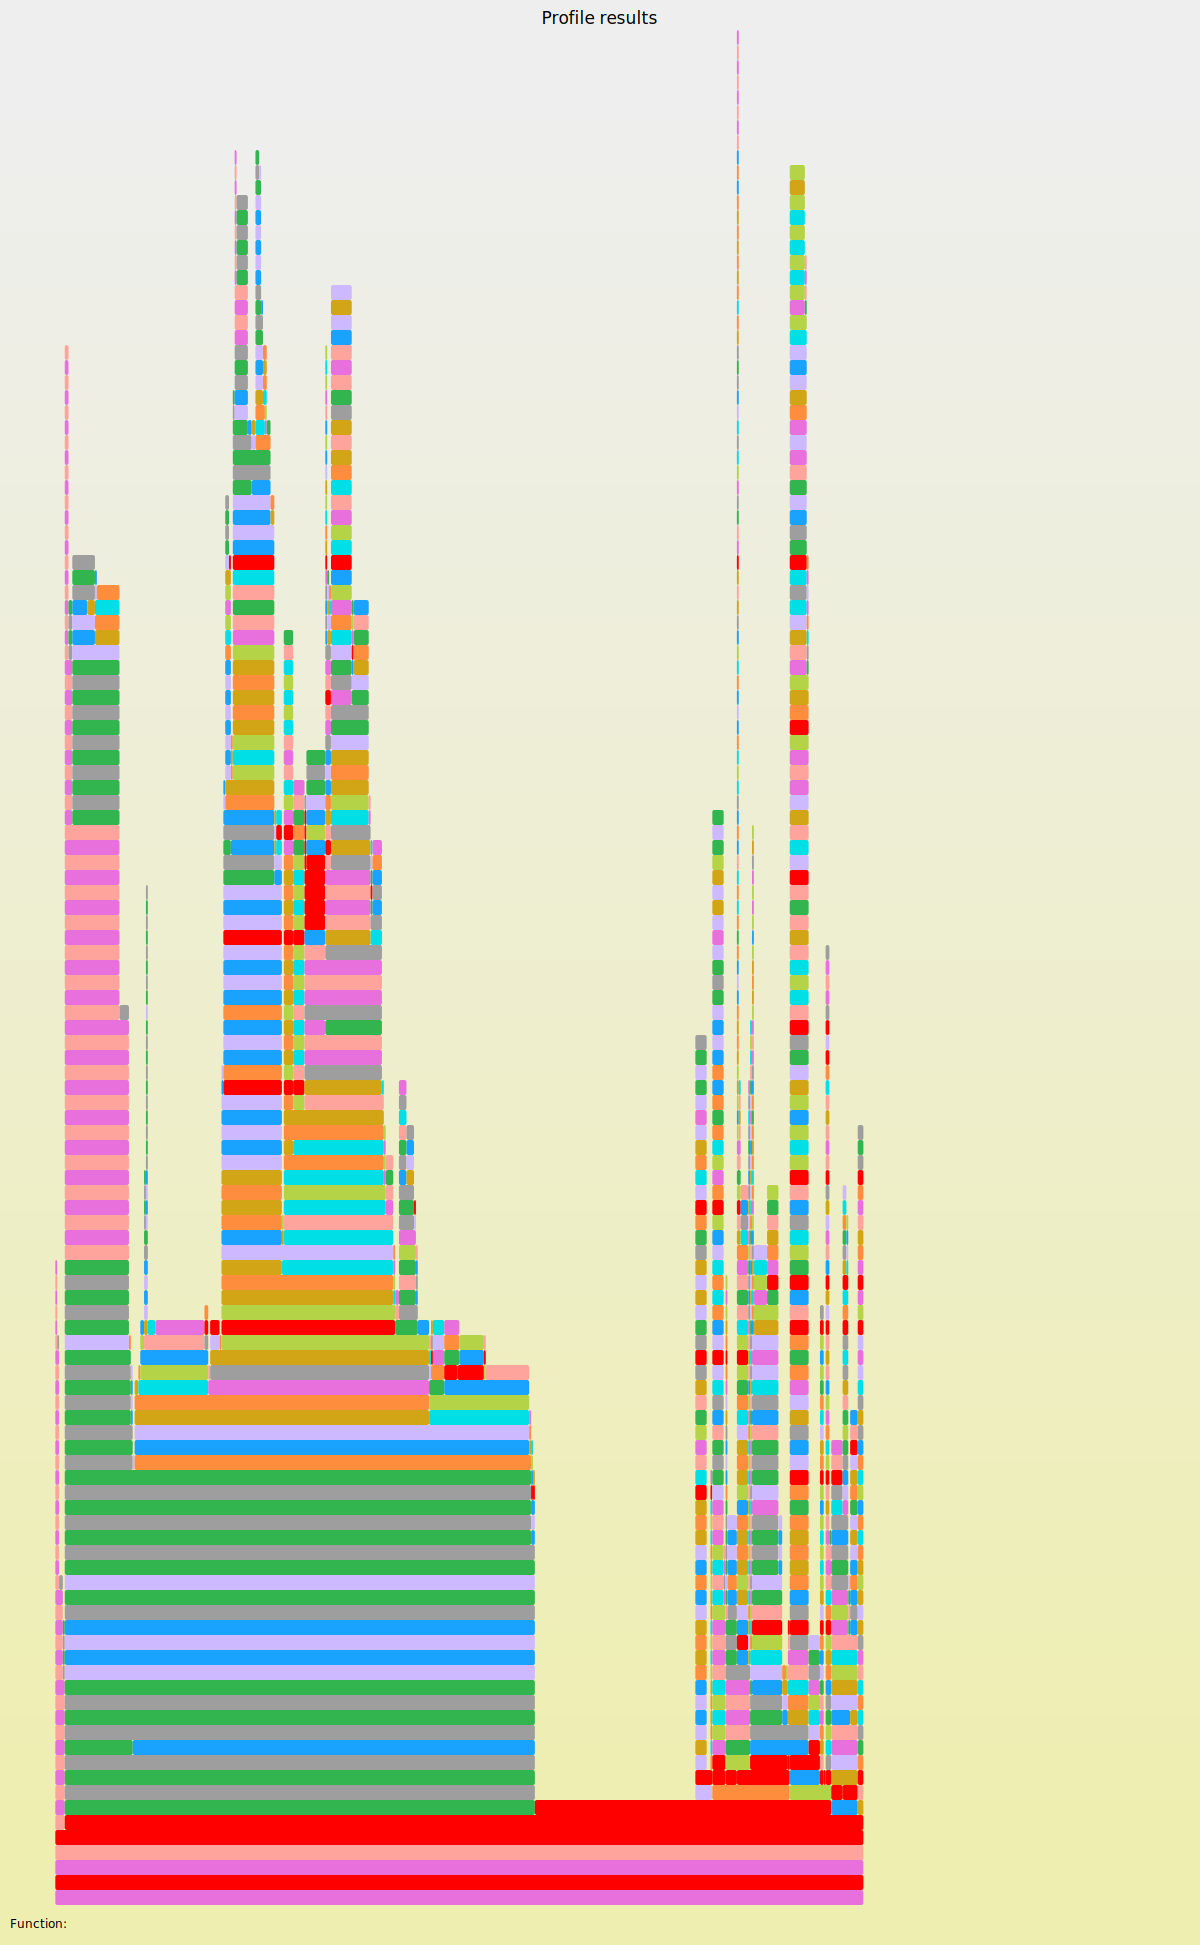

In [11]:
using Profile
using ProfileView 
env = setUpEnvironment()
N = 20
x_init = [0.6; 2.4; 0; 0; 0; 0]
x_goal = [3.; 0.5; 0; 0.05; -0.05; 0]
TOP, TOSgusto = setUpProblem(N, x_init, x_goal);
Profile.clear()
@profile solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, init_traj_straightline, "Gurobi", OutputFlag=0)
ProfileView.view()


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************



┌ Warning: The profile data buffer is full; profiling probably terminated
│ before your program finished. To profile for longer runs, call
│ `Profile.init()` with a larger buffer and/or larger delay.
└ @ Profile /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.0/Profile/src/Profile.jl:312


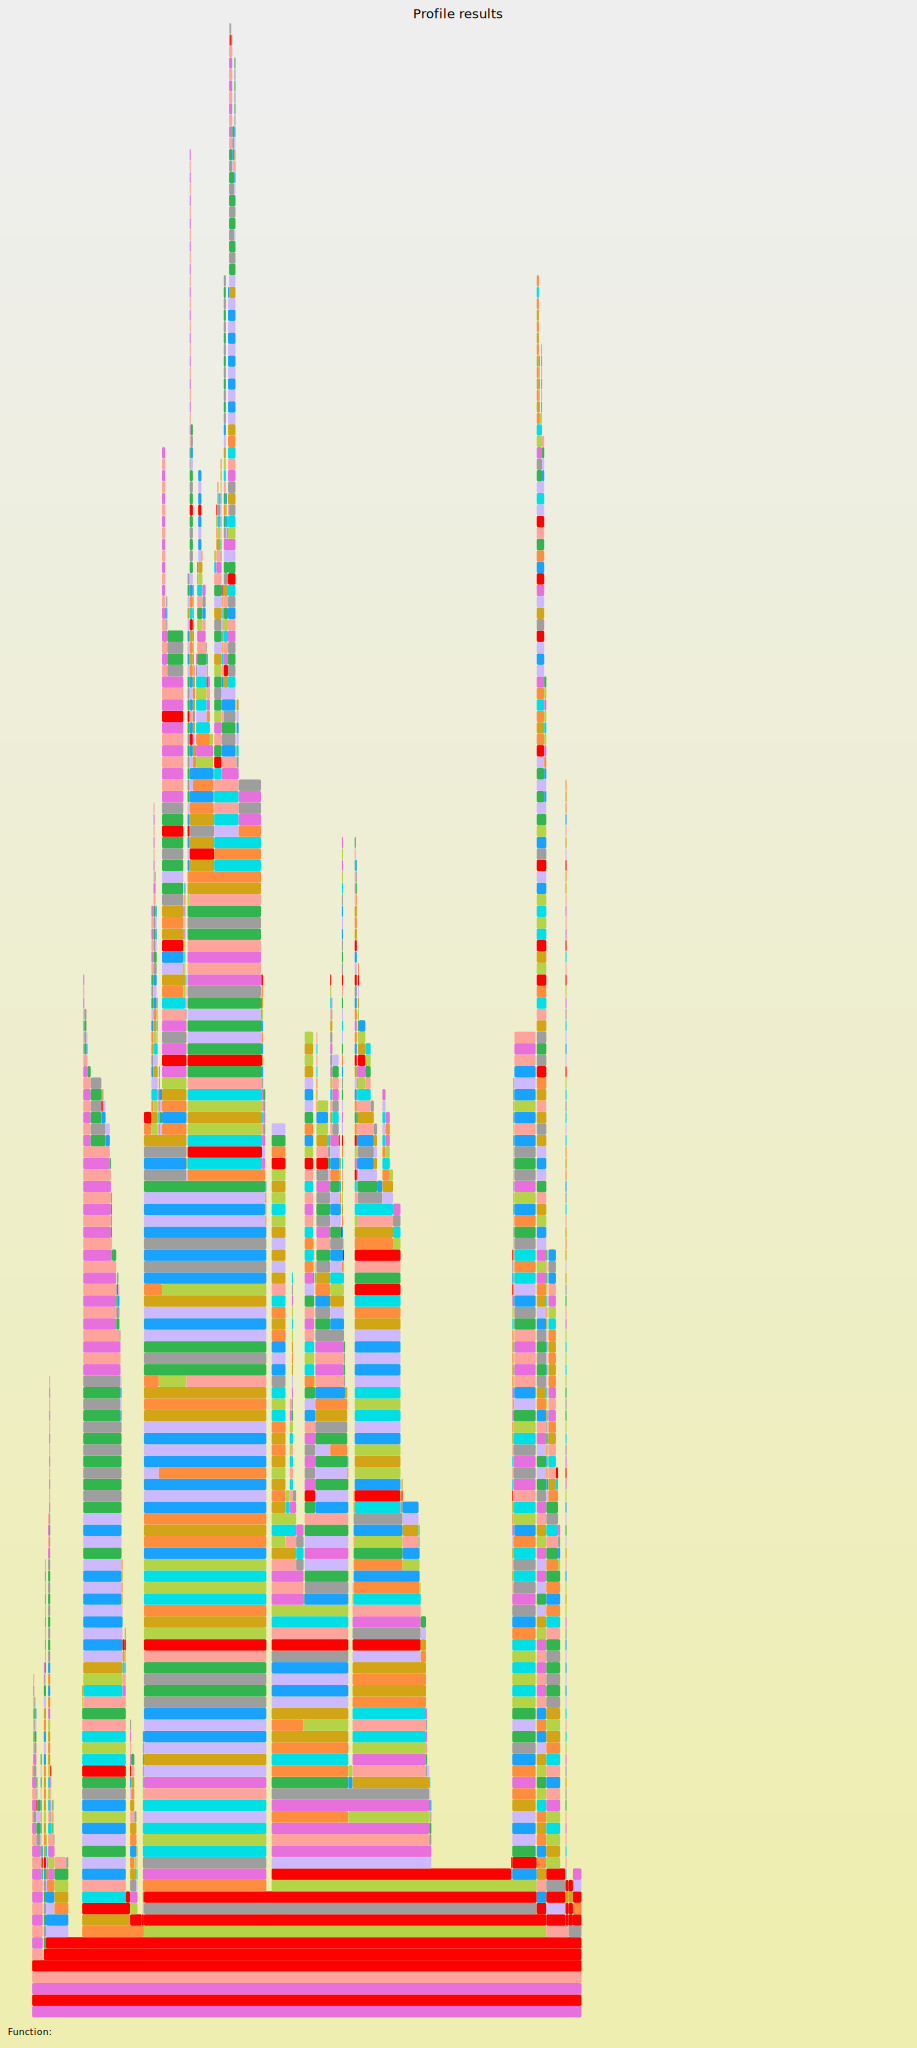

In [12]:
using Profile
using ProfileView 
env = setUpEnvironment()
N = 20
x_init = [0.6; 2.4; 0; 0; 0; 0]
x_goal = [3.; 0.5; 0; 0.05; -0.05; 0]
TOP, TOSgusto = setUpProblem(N, x_init, x_goal);
Profile.clear()
@profile solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, init_traj_straightline, "Ipopt", print_level=0)
ProfileView.view()

In [22]:
SCPS = solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, init_traj_straightline, "Gurobi", OutputFlag=0);
# SCPS = solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, init_traj_straightline, "Ipopt", print_level=0);


Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only


In [23]:
@show TOSgusto.SCPS.converged
@show TOSgusto.SCPS.iterations
@show TOSgusto.SCPS.total_time
@show TOSgusto.SCPS.accept_solution
@show TOSgusto.SCPS.solver_status
@show TOSgusto.SCPS.scp_status
@show TOSgusto.SCPS.convergence_measure
@show TOSgusto.SCPS.param.alg.ω_vec
@show TOSgusto.SCPS.param.alg.Δ_vec
@show TOSgusto.SCPS.J_true
@show TOSgusto.SCPS.dual
;

(TOSgusto.SCPS).converged = true
(TOSgusto.SCPS).iterations = 6
(TOSgusto.SCPS).total_time = 6.451426258000001
(TOSgusto.SCPS).accept_solution = Bool[true, true, true, true, true, true, true]
(TOSgusto.SCPS).solver_status = Union{TerminationStatusCode, Symbol}[:NA, OPTIMAL, OPTIMAL, OPTIMAL, OPTIMAL, OPTIMAL, OPTIMAL]
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
(TOSgusto.SCPS).convergence_measure = [0.0, 0.121476, 0.0849042, 0.0464864, 0.0146997, 0.00463386, 0.00146759]
(((TOSgusto.SCPS).param).alg).ω_vec = [2.0, 20.0, 200.0, 2000.0, 20000.0, 200000.0, 2.0e6]
(((TOSgusto.SCPS).param).alg).Δ_vec = [4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0]
(TOSgusto.SCPS).J_true = Any[0.0, 0.253129, 0.29253, 0.230932, 0.208509, 0.203066, 0.201448]
(TOSgusto.SCPS).dual = [NaN, NaN, NaN, NaN, NaN, NaN]


┌ Info: Serving MeshCat visualizer at http://127.0.0.1:8700
└ @ MeshCat /home/somrita/.julia/packages/MeshCat/WlA0B/src/servers.jl:24


Process(`xdg-open http://127.0.0.1:8700`, ProcessExited(0))

Opening in existing browser session.


In [11]:
@show TOSgusto.SCPS.traj


(TOSgusto.SCPS).traj = Trajectory([0.2 0.201861 0.20669 0.213193 0.220707 0.229091 0.238307 0.248317 0.259084 0.27057 0.282736 0.295545 0.308958 0.322938 0.337448 0.352448 0.367901 0.383769 0.400015 0.416599 0.433486 0.450635 0.46801 0.485573 0.503285 0.521109 0.539007 0.556941 0.574872 0.592764 0.610578 0.628276 0.64582 0.663173 0.680296 0.697151 0.713701 0.729908 0.745733 0.761139 0.776088 0.790543 0.804464 0.817814 0.830555 0.842651 0.854073 0.8648 0.87482 0.884123 0.892712 0.900602 0.907824 0.91442 0.920448 0.925975 0.931074 0.935815 0.940269 0.944507 0.948601 0.95262 0.956636 0.96072 0.964942 0.969375 0.974089 0.979152 0.98463 0.990576 0.997039 1.00406 1.01166 1.01984 1.02857 1.03781 1.04754 1.05773 1.06834 1.07934 1.09071 1.10241 1.11441 1.12668 1.13918 1.1519 1.16479 1.17783 1.19098 1.20421 1.2175 1.23081 1.24411 1.25736 1.27055 1.28364 1.29659 1.30937 1.32196 1.33433 1.34643 1.35825 1.36975 1.3809 1.39167 1.40202 1.41195 1.42147 1.43057 1.43929 1.44765 1.45566 1.46334 1.47071 1

Trajectory([0.2 0.201861 … 2.95056 3.0; 2.4 2.40014 … 0.548898 0.5; … ; 0.0 0.000281264 … -0.0473063 -0.05; 0.0 -7.5365e-10 … -7.41985e-9 0.0], [0.0722958 0.0509128 … 0.0266829 0.0273053; 0.00476795 0.00459049 … -0.0446385 -0.0449888; -1.36909e-10 -1.39048e-10 … 1.20121e-9 1.51581e-9], 200.0, 1.0050251256281406)

In [2]:
typeof(TOSgusto.SCPS.traj)


UndefVarError: UndefVarError: TOSgusto not defined

In [ ]:
# Old version of code
# # Violates constraints start point
# env = setUpEnvironment()
# N = 20
# x_init = [0.6; 2.4; 0; 0; 0; 0]
# x_goal = [3.; 0.5; 0; 0.05; -0.05; 0]
# TOP, TOSgusto = setUpProblem(N, x_init, x_goal);
# if isdefined(TOSgusto, :SCPS)
#     println("Before first, TOSgusto.SCPS defined")
# else
#     println("Before first, TOSgusto.SCPS NOT defined")
# end
# # Solve one step at a time with IPOPT
# solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, init_traj_straightline, "Ipopt", max_iter=1, print_level=0);
# # @show typeof(TOSgusto.SCPS.SCPP.param.alg)
# iterCount = 1
# if isdefined(TOSgusto.SCPS.param, :alg)
#     println("After first, TOSgusto.SCPS.param.alg defined")
# else
#     println("After first, TOSgusto.SCPS.param.alg NOT defined")
# end
# while !TOSgusto.SCPS.converged && iterCount <=15
#     solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, TOSgusto.SCPS.traj, "Ipopt", max_iter=1, print_level=0);
#     iterCount = iterCount + 1
#     @show iterCount 
#     @show TOSgusto.SCPS.param.alg.ω_vec
#     @show TOSgusto.SCPS.param.alg.Δ_vec
# end
# println("Finished!")
# @show TOSgusto.SCPS.scp_status
# @show TOSgusto.SCPS.iterations
# @show TOSgusto.SCPS.converged
# @show TOSgusto.SCPS.param.alg.ω_vec
# @show TOSgusto.SCPS.param.alg.Δ_vec